<center><h1>Sales Prediction</h1></center>

<B>Name -</B> Churchill @ Nirvana Codes

<B> - </B> 

<B>Department -</B> 

<B>Project -</B> Stores Sales Prediction (A case study of Shop@ABC)

<B>Email -</B> 

<B>Mobile No. </B> +234 

<hr/>

### Business Context:

A large grocery retailer (Shop@ABC) operates multiple stores in the US. 

Demand planning for the stores is a crucial element to ensure the stores are not overstocked or under-stocked, thus enabling a competitive edge in the market. However, the business currently believe that they are not able to leverage the power of data driven analytics solution for the same. 

<hr/>

### Problem Statement

The store managers needs to be empowered with data analytics solutions/ tools, which enables them to predict daily sales for up to a month in advance.

The store sales are impacted by many factors, including various types of promotions, holiday seasons, and various store demographics, among others. 

It is important to understand various factors that affects the demand of the stores and also develop accurate demand forecasting models for the stores

<hr/>

### Desired Outcome:

Using the attached public data, the following is done with analytics approach:

- Understanding of the different data fields
- Data cleaning/ manipulations and business/ technical logics involved
- Analytical findings and insights (EDA)
- Forecast model development and performance measures
- How would one measure the improvement driven by the solution provided?
- Suggested Next steps

<hr/>

Phase 1

### 1.1 Import necessary libraries

In [3]:
# Data representation and computation
import pandas as pd  
import numpy as np  
pd.options.display.float_format = '{:20,.4f}'.format

# Graph plotting
import matplotlib.pyplot as plt  
import seaborn as sns

# prophet by Facebook
from prophet import Prophet

# Miscellaneous
import warnings
from math import log, e, ceil
from scipy.stats import entropy
# from prettytable import PrettyTable

# Declaration
warnings.filterwarnings('ignore')
%precision 2
%matplotlib inline
sns.set(font_scale=1)

<br><hr/>

### 1.2 Load Data

We have historical sales data for 1115 Stores. The task is to forecast the "Sales".

### Files
- sales.csv - historical sales data
- store.csv - information about the stores

### Data fields

#### Sales
- StoreID - a unique Id for each store
- Date - Date
- Sales - the turnover for any given day (this is what we are predicting)
- Customers - the number of customers on a given day
- StoreOpen - an indicator for whether the store was open: 0 = closed, 1 = open
- PromoFlag - indicates whether a store is running a promo on that day
- HolidayFlag - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. h1 = public holiday, h2 = Easter holiday, h3 = Christmas, 0 = None
- SchUnivClose - indicates if the (Store, Date) was affected by the closure of public schools


#### Store
- StoreID - a unique Id for each store
- LocalityType - differentiates between 4 different store models: type1, type2, type3, type4
- ProductMix - Essentials, EssentialsPlus, LargeVariety
- PromoCont - PromoCont is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- PromoContStartWeek - describes the year and calendar week when the store started participating in PromoCont
- PromoContStartYear - describes the year and calendar week when the store started participating in PromoCont
- PromoContInterval - describes the consecutive intervals PromoCont is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionMonth - gives the approximate month of the time the nearest competitor was opened
- CompetitionYear - gives the approximate year of the time the nearest competitor was opened

In [4]:
# The data is of a particular time period. 
# To read the data as a time series, we have to pass special arguments to the read_csv command:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')

ldf_sales_data = pd.read_csv('sales.csv', parse_dates=['Date'], date_parser=dateparse)
ldf_store_data = pd.read_csv('store.csv')

In [5]:
ldf_training_dataset = pd.merge(ldf_store_data, 
                                ldf_sales_data, 
                                on ='StoreID',
                                how ='inner')

# first glance at the dataset: head and tail
print("In total: ", ldf_training_dataset.shape)
ldf_training_dataset.head(5).append(ldf_training_dataset.tail(5))

In total:  (731609, 18)


,StoreID,LocalityType,ProductMix,PromoCont,PromoContStartWeek,PromoContStartYear,PromoContInterval,CompetitionDistance,CompetitionMonth,CompetitionYear,DOW,Date,Sales,Customers,StoreOpen,PromoFlag,HolidayFlag,SchUnivClose
0,1,type3,Essentials,0,NaN,NaN,NaN,"1,270.0000",9.0000,"2,008.0000",7,2015-05-31,0,0,0,0,0,0
1,1,type3,Essentials,0,NaN,NaN,NaN,"1,270.0000",9.0000,"2,008.0000",6,2015-05-30,5592,580,1,0,0,0
2,1,type3,Essentials,0,NaN,NaN,NaN,"1,270.0000",9.0000,"2,008.0000",5,2015-05-29,4656,537,1,0,0,0
3,1,type3,Essentials,0,NaN,NaN,NaN,"1,270.0000",9.0000,"2,008.0000",4,2015-05-28,4111,474,1,0,0,0
4,1,type3,Essentials,0,NaN,NaN,NaN,"1,270.0000",9.0000,"2,008.0000",3,2015-05-27,4083,497,1,0,0,0
731604,1115,type4,LargeVariety,1,22.0000,"2,012.0000","Mar,Jun,Sept,Dec","5,350.0000",NaN,NaN,6,2013-01-05,4771,339,1,0,0,1
731605,1115,type4,LargeVariety,1,22.0000,"2,012.0000","Mar,Jun,Sept,Dec","5,350.0000",NaN,NaN,5,2013-01-04,4540,326,1,0,0,1
731606,1115,type4,LargeVariety,1,22.0000,"2,012.0000","Mar,Jun,Sept,Dec","5,350.0000",NaN,NaN,4,2013-01-03,4297,300,1,0,0,1
731607,1115,type4,LargeVariety,1,22.0000,"2,012.0000","Mar,Jun,Sept,Dec","5,350.0000",NaN,NaN,3,2013-01-02,3697,305,1,0,0,1
731608,1115,type4,LargeVariety,1,22.0000,"2,012.0000","Mar,Jun,Sept,Dec","5,350.0000",NaN,NaN,2,2013-01-01,0,0,0,0,h1,1


<br><hr/>

### 1.3. Data Preprocessing

> Here we'll quickly describe a dataset; the number of rows/columns, missing data, data types, preview, etc.

In [6]:
ldf_training_dataset.shape

(731609, 18)

In [7]:
ldf_training_dataset.describe()

,StoreID,PromoCont,PromoContStartWeek,PromoContStartYear,CompetitionDistance,CompetitionMonth,CompetitionYear,DOW,Sales,Customers,StoreOpen,PromoFlag,SchUnivClose
count,"731,609.0000","731,609.0000","370,770.0000","370,770.0000","729,672.0000","499,200.0000","499,200.0000","731,609.0000","731,609.0000","731,609.0000","731,609.0000","731,609.0000","731,609.0000"
mean,558.1977,0.5068,23.4469,"2,011.7587","5,416.5151",7.2239,"2,008.6787",3.9997,"5,731.7071",627.8894,0.8211,0.3725,0.1295
std,321.8893,0.5000,14.1152,1.6687,"7,685.4211",3.2110,6.1009,1.9996,"3,909.0319",468.3040,0.3833,0.4835,0.3357
min,1.0000,0.0000,1.0000,"2,009.0000",20.0000,1.0000,"1,900.0000",1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,280.0000,0.0000,13.0000,"2,011.0000",710.0000,4.0000,"2,006.0000",2.0000,"3,628.0000",394.0000,1.0000,0.0000,0.0000
50%,558.0000,1.0000,22.0000,"2,012.0000","2,330.0000",8.0000,"2,010.0000",4.0000,"5,713.0000",606.0000,1.0000,0.0000,0.0000
75%,837.0000,1.0000,37.0000,"2,013.0000","6,890.0000",10.0000,"2,013.0000",6.0000,"7,847.0000",837.0000,1.0000,1.0000,0.0000
max,"1,115.0000",1.0000,50.0000,"2,015.0000","75,860.0000",12.0000,"2,015.0000",7.0000,"38,722.0000","7,388.0000",1.0000,1.0000,1.0000


In [8]:
ldf_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731609 entries, 0 to 731608
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   StoreID              731609 non-null  int64         
 1   LocalityType         731609 non-null  object        
 2   ProductMix           731609 non-null  object        
 3   PromoCont            731609 non-null  int64         
 4   PromoContStartWeek   370770 non-null  float64       
 5   PromoContStartYear   370770 non-null  float64       
 6   PromoContInterval    370770 non-null  object        
 7   CompetitionDistance  729672 non-null  float64       
 8   CompetitionMonth     499200 non-null  float64       
 9   CompetitionYear      499200 non-null  float64       
 10  DOW                  731609 non-null  int64         
 11  Date                 731609 non-null  datetime64[ns]
 12  Sales                731609 non-null  int64         
 13  Customers     

In [9]:
ldf_training_dataset.isna().sum()

StoreID                     0
LocalityType                0
ProductMix                  0
PromoCont                   0
PromoContStartWeek     360839
PromoContStartYear     360839
PromoContInterval      360839
CompetitionDistance      1937
CompetitionMonth       232409
CompetitionYear        232409
DOW                         0
Date                        0
Sales                       0
Customers                   0
StoreOpen                   0
PromoFlag                   0
HolidayFlag                 0
SchUnivClose                0
dtype: int64

<br/><hr/>

# 2. Exploratory Data Analysis (EDA)

The purpose of this EDA is to find insights that will serve us later for Data cleaning/preparation/transformation which will ultimately be used into a machine learning algorithm.


We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [10]:
# data extraction
ldf_training_dataset['Year'] = ldf_training_dataset.Date.dt.year
ldf_training_dataset['Month'] = ldf_training_dataset.Date.dt.month
ldf_training_dataset['Day'] = ldf_training_dataset.Date.dt.day
ldf_training_dataset['WeekOfYear'] = ldf_training_dataset.Date.dt.weekofyear

# adding new variable
ldf_training_dataset['SalePerCustomer'] = ldf_training_dataset['Sales']/ldf_training_dataset['Customers']
ldf_training_dataset['SalePerCustomer'].describe()

count           600,660.0000
mean                  9.4975
std                   2.1928
min                   0.0000
25%                   7.8974
50%                   9.2535
75%                  10.9076
max                  57.6150
Name: SalePerCustomer, dtype: float64

On average customers spend about `9.50$` per day. Though there are days with Sales equal to `zero`.

### 2.1 Dealing with missing values

In [11]:
# closed stores
len(ldf_training_dataset[(ldf_training_dataset.StoreOpen == 0) & \
                         (ldf_training_dataset.Sales == 0)])/len(ldf_training_dataset)

0.18

There're 172817 closed stores in the data. It is about 17% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [12]:
# opened stores with zero sales
zero_sales = ldf_training_dataset[(ldf_training_dataset.StoreOpen != 0) & (ldf_training_dataset.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (39, 23)


,StoreID,LocalityType,ProductMix,PromoCont,PromoContStartWeek,PromoContStartYear,PromoContInterval,CompetitionDistance,CompetitionMonth,CompetitionYear,...,Customers,StoreOpen,PromoFlag,HolidayFlag,SchUnivClose,Year,Month,Day,WeekOfYear,SalePerCustomer
16150,25,type3,Essentials,0,NaN,NaN,NaN,430.0000,4.0000,"2,003.0000",...,0,1,0,0,0,2014,2,13,7,NaN
16151,25,type3,Essentials,0,NaN,NaN,NaN,430.0000,4.0000,"2,003.0000",...,0,1,0,0,0,2014,2,12,7,NaN
18007,28,type1,Essentials,1,6.0000,"2,015.0000","Mar,Jun,Sept,Dec","1,200.0000",10.0000,"2,014.0000",...,0,1,1,0,0,2014,9,4,36,NaN
18008,28,type1,Essentials,1,6.0000,"2,015.0000","Mar,Jun,Sept,Dec","1,200.0000",10.0000,"2,014.0000",...,0,1,1,0,1,2014,9,3,36,NaN
18009,28,type1,Essentials,1,6.0000,"2,015.0000","Mar,Jun,Sept,Dec","1,200.0000",10.0000,"2,014.0000",...,0,1,1,0,1,2014,9,2,36,NaN


Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved.

In [13]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
ldf_training_dataset = ldf_training_dataset[(ldf_training_dataset["StoreOpen"] != 0) & (ldf_training_dataset['Sales'] != 0)]

print("In total: ", ldf_training_dataset.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (600658, 23)


### 2.2 Store Data Analysis

In [14]:
ldf_store_data.isnull().sum()

StoreID                  0
LocalityType             0
ProductMix               0
PromoCont                0
PromoContStartWeek     544
PromoContStartYear     544
PromoContInterval      544
CompetitionDistance      3
CompetitionMonth       354
CompetitionYear        354
dtype: int64

We have few variables with missing values that we need to deal with. Let's start with the `CompetitionDistance`.

In [15]:
# missing values in CompetitionDistance
ldf_store_data[pd.isnull(ldf_store_data.CompetitionDistance)]

,StoreID,LocalityType,ProductMix,PromoCont,PromoContStartWeek,PromoContStartYear,PromoContInterval,CompetitionDistance,CompetitionMonth,CompetitionYear
290,291,type4,Essentials,0,NaN,NaN,NaN,NaN,NaN,NaN
621,622,type1,LargeVariety,0,NaN,NaN,NaN,NaN,NaN,NaN
878,879,type4,Essentials,1,5.0000,"2,013.0000","Feb,May,Aug,Nov",NaN,NaN,NaN


In [16]:
# fill NaN with a median value (skewed distribuion)
ldf_store_data['CompetitionDistance'].fillna(ldf_store_data['CompetitionDistance'].median(), inplace = True)

### 2.3 Locality Type Analysis

In this section we will closely look at different levels of `LocalityType` and how the main metric `Sales` is distributed among them.

In [17]:
ldf_training_dataset.groupby('LocalityType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
LocalityType,,,,,,,,
type1,"324,377.0000","6,950.2767","3,312.0461",124.0000,"4,701.0000","6,298.0000","8,432.0000","38,025.0000"
type2,"10,995.0000","10,255.7314","5,248.5794","1,452.0000","6,311.5000","9,117.0000","13,251.5000","38,722.0000"
type3,"79,754.0000","6,981.1803","2,969.8092",133.0000,"4,930.0000","6,425.0000","8,400.0000","31,448.0000"
type4,"185,532.0000","6,841.5141","2,598.7817",538.0000,"5,048.0000","6,396.0000","8,147.0000","38,037.0000"


`LocalityType - type2` has the highest average of `Sales` among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [18]:
ldf_training_dataset.groupby('LocalityType')['Customers', 'Sales'].sum()

,Customers,Sales
LocalityType,,
type1,258790561,2254509914
type2,22142649,112761767
type3,65617491,556777056
type4,112818848,1269319792


Clearly stores of `type 1` is the most selling and crowded one. `type 4` goes on the second place in both Sales and Customers.

What about date periods? Seaborn's facet grid is the best tool for this task:

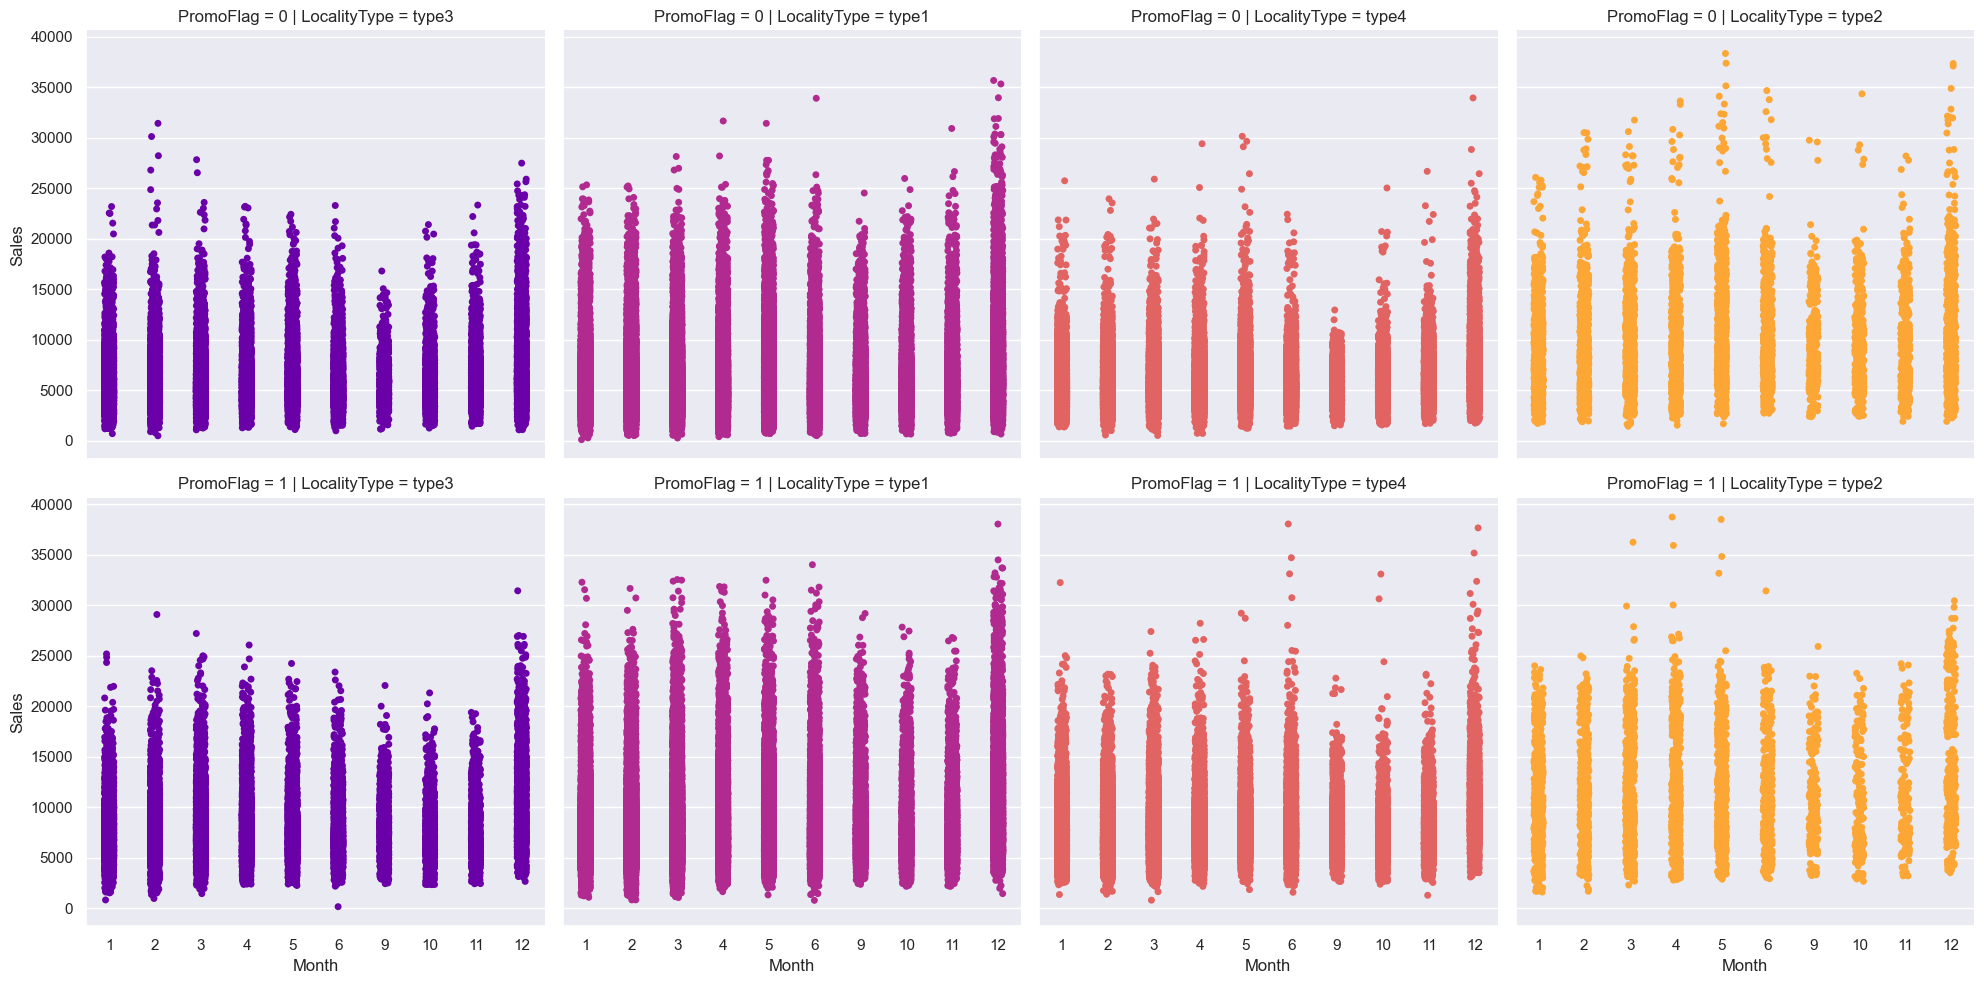

In [19]:
# sales trends
sns.catplot(data = ldf_training_dataset, x = 'Month', y = "Sales", 
               col = 'LocalityType', # per store type in cols
               palette = 'plasma',
               hue = 'LocalityType',
               row = 'PromoFlag') 

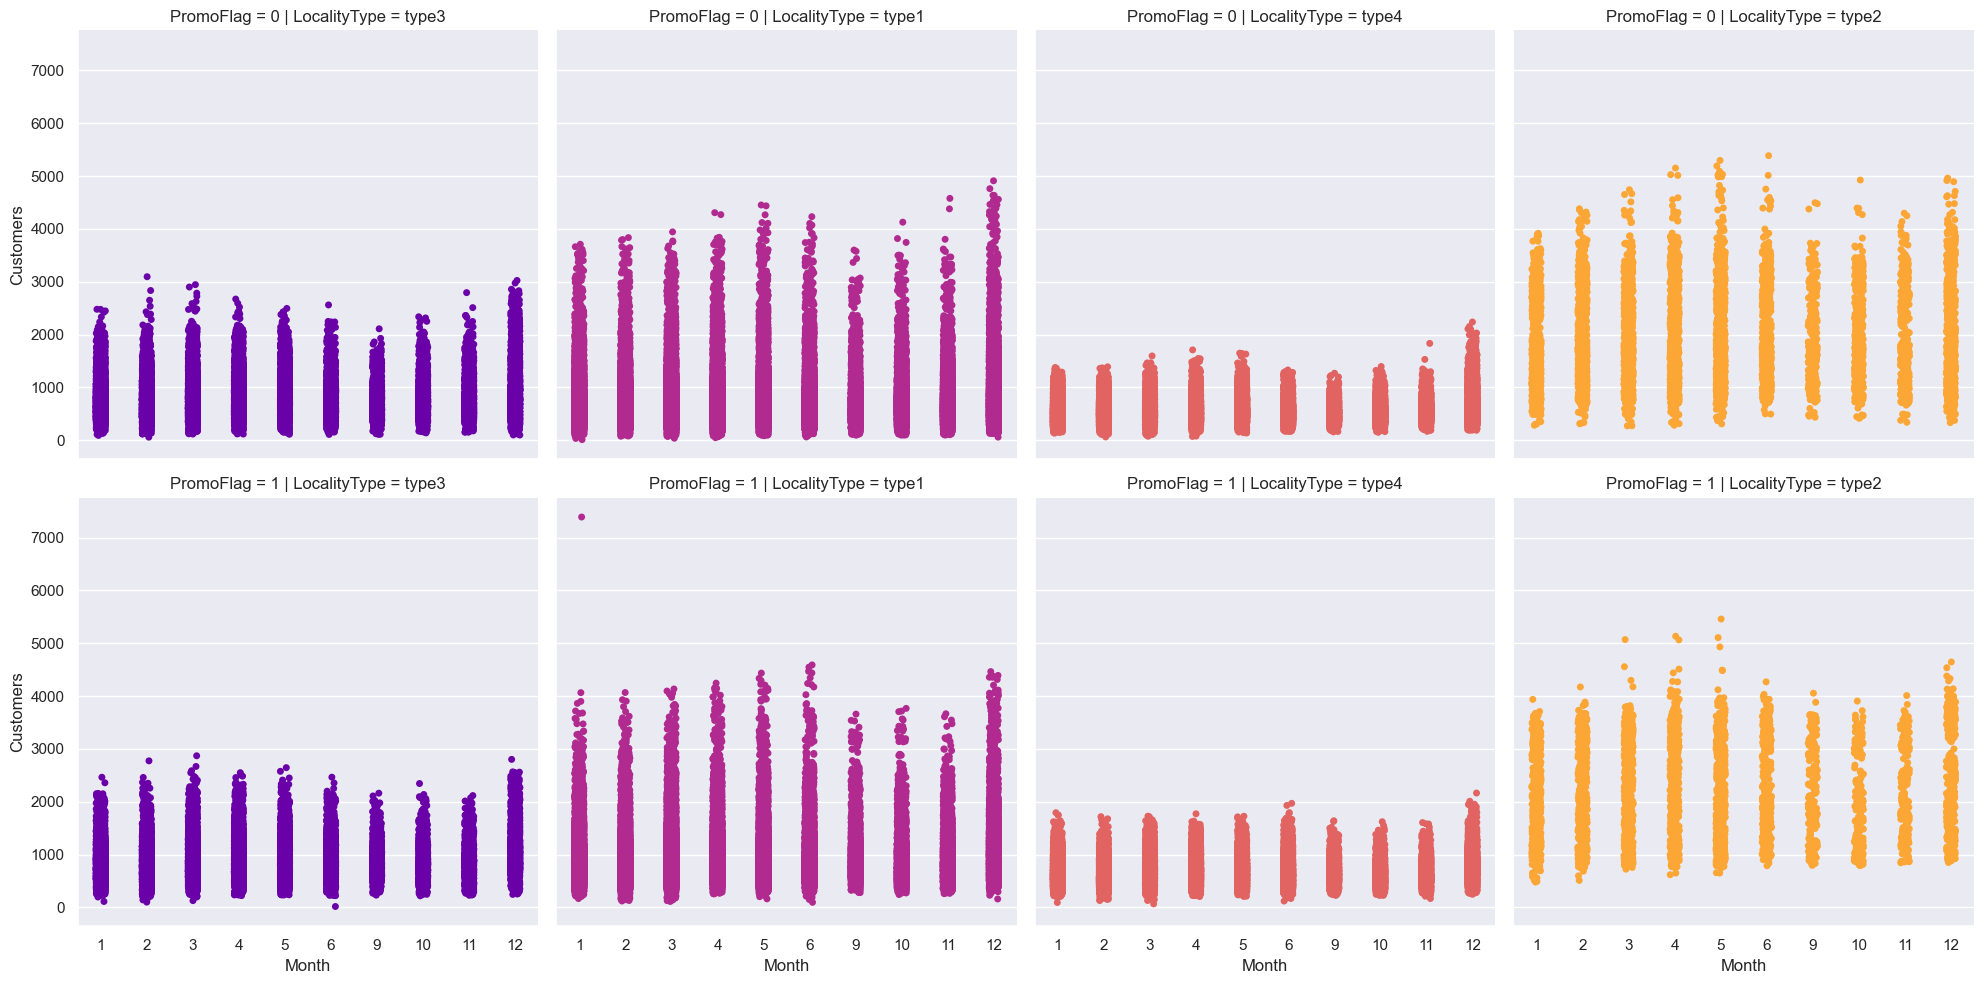

In [20]:
# sales trends
sns.catplot(data = ldf_training_dataset, x = 'Month', y = "Customers", 
               col = 'LocalityType', # per store type in cols
               palette = 'plasma',
               hue = 'LocalityType',
               row = 'PromoFlag') 

All LocalityTypes follow the same trend but at different scales.

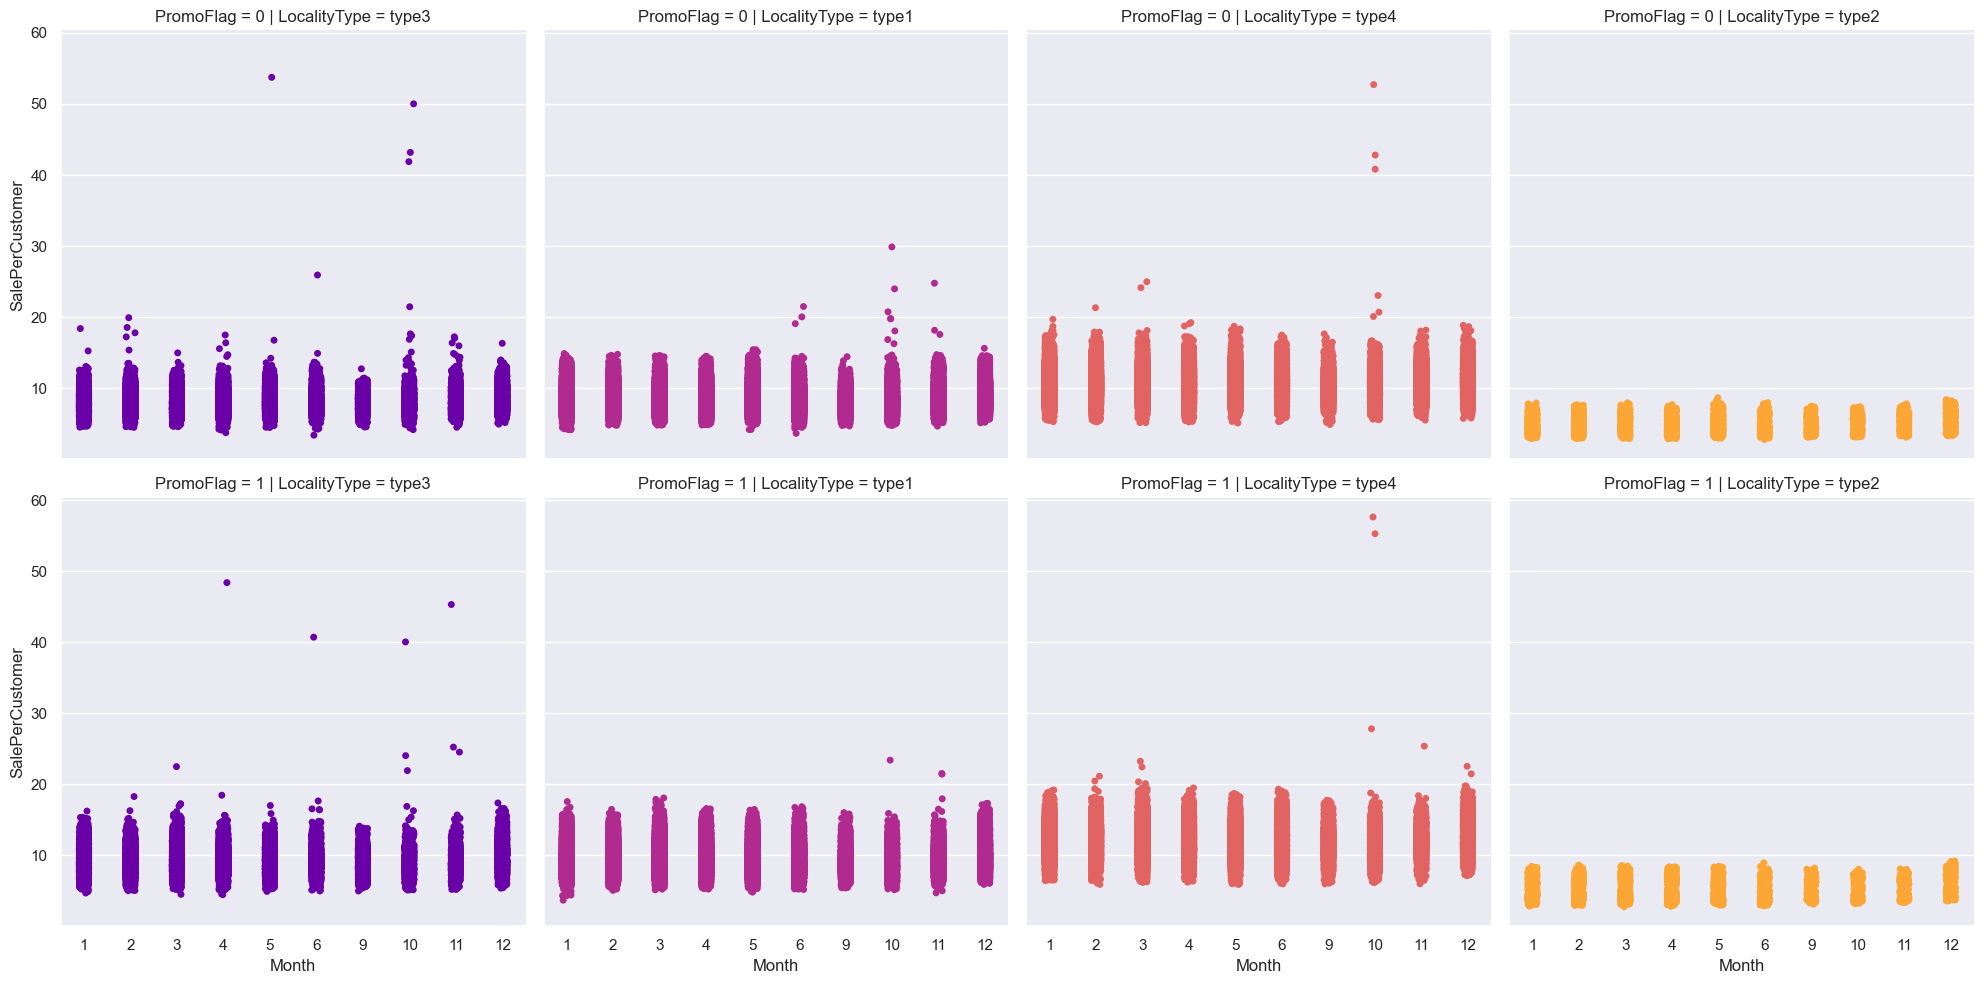

In [21]:
# sales trends
sns.catplot(data = ldf_training_dataset, x = 'Month', y = "SalePerCustomer", 
               col = 'LocalityType', # per store type in cols
               palette = 'plasma',
               hue = 'LocalityType',
               row = 'PromoFlag') 

Interesting! Eventhough the plots above showed `LocalityType 2` as the most selling and performant one, in reality it is not true. The highest `SalePerCustomer` amount is observed at the `LocalityType 4`, about `12$` with Promo and `10$` without. As for LocalityType 1 and 3 it is about `9$`.

Low SalePerCustomer amount for `LocalityType 2` describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this LocalityType generated the least amount of sales and customers over the period.

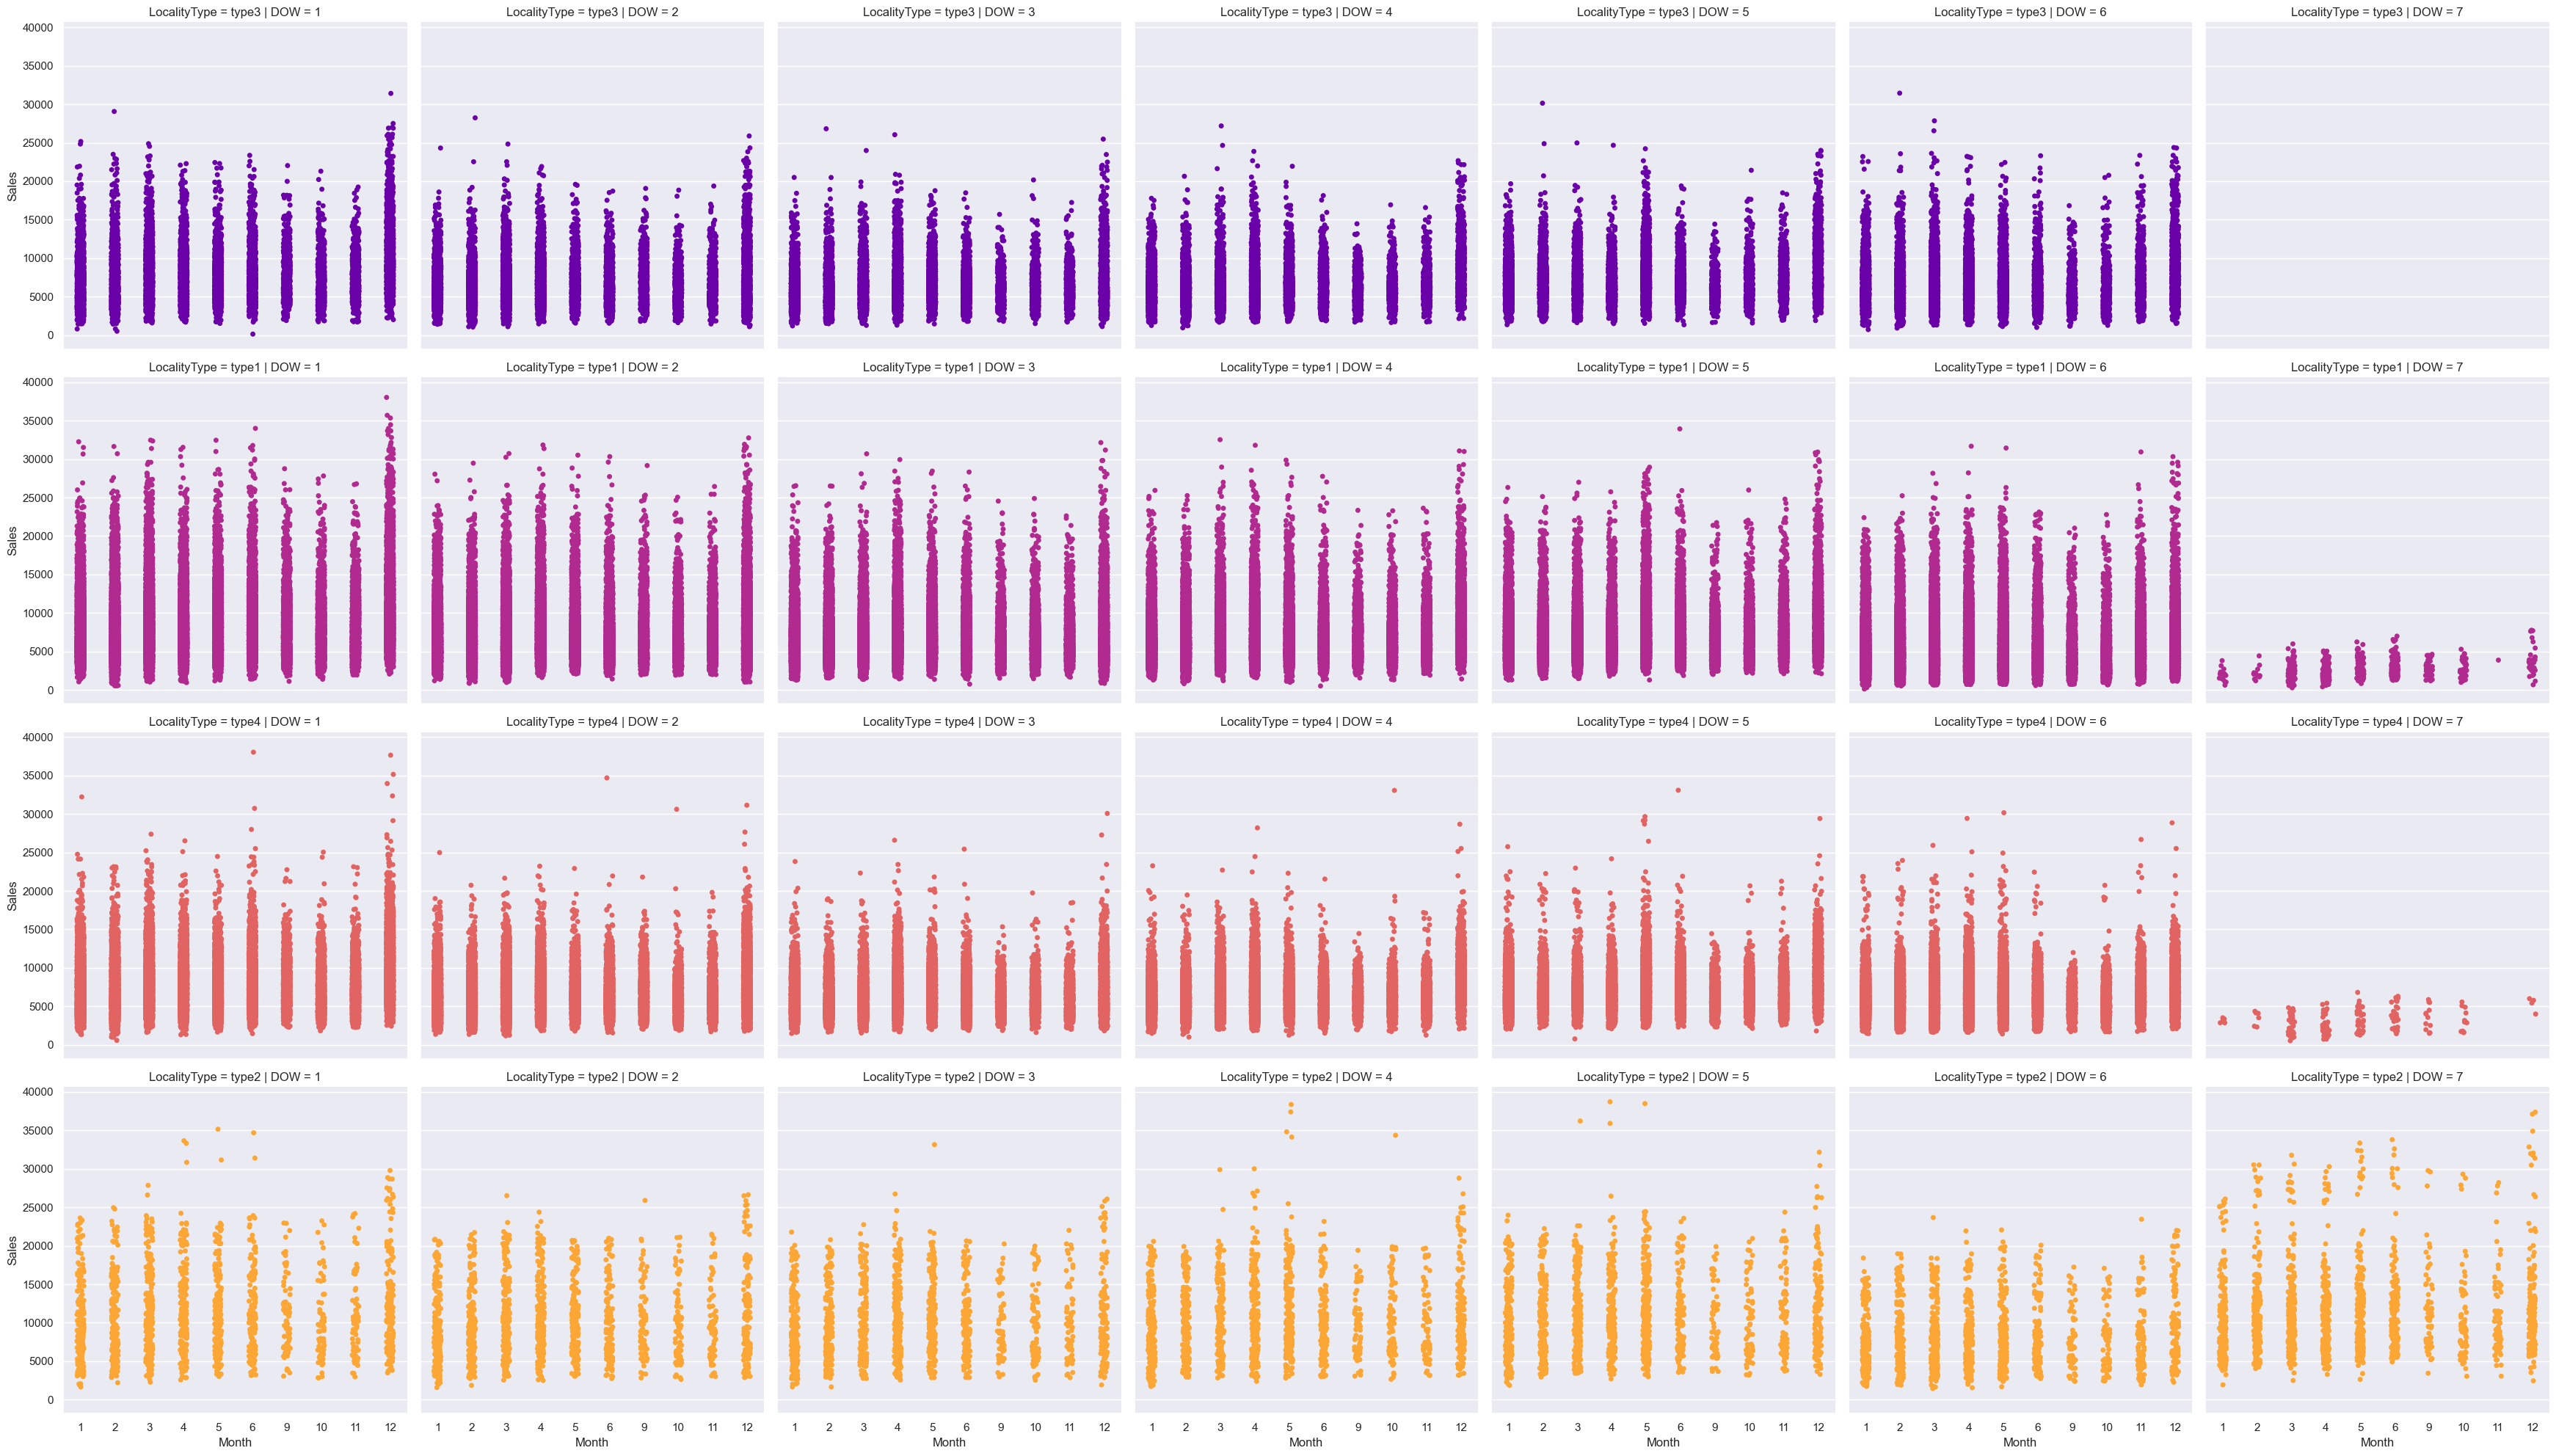

In [22]:
# sales trends
sns.catplot(data = ldf_training_dataset, x = 'Month', y = "Sales", 
               col = 'DOW', # per store type in cols
               palette = 'plasma',
               hue = 'LocalityType',
               row = 'LocalityType') 

We see that stores of `LocalityType 3` are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of `LocalityType 4` are closed on Sundays only from October to December.

### 2.4 Correlational Analysis

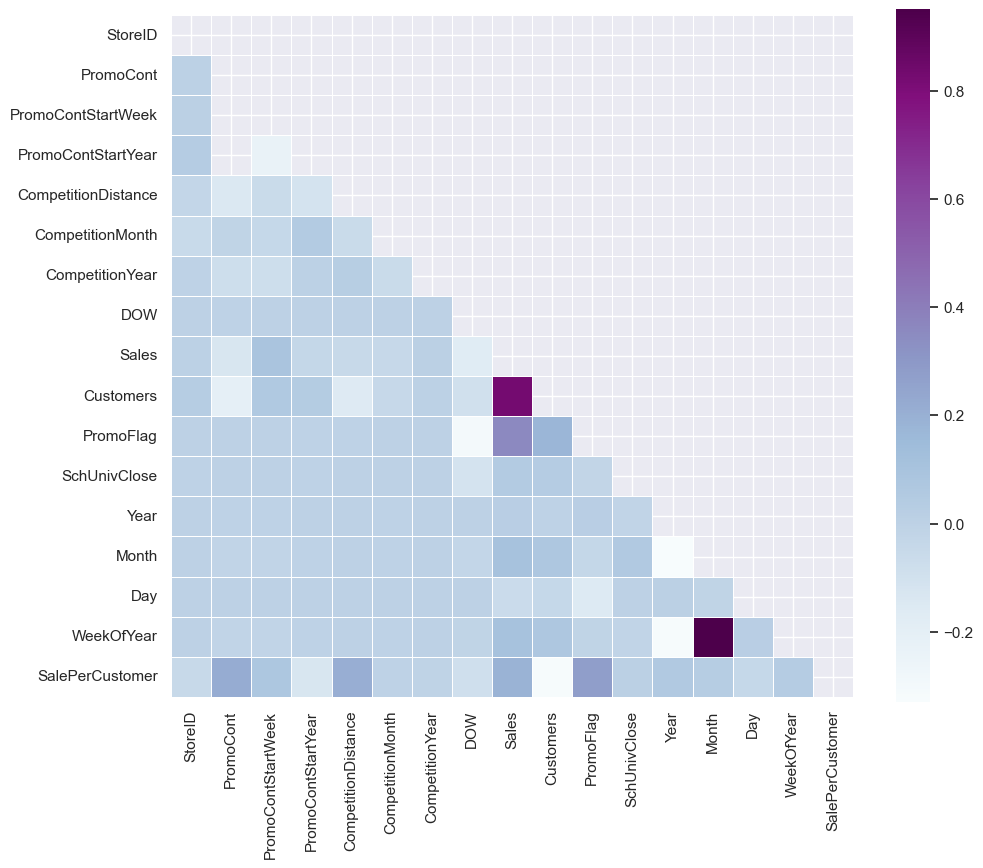

In [24]:
# Compute the correlation matrix 
# exclude 'StoreOpen' variable
corr_all = ldf_training_dataset.drop('StoreOpen', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion `(PromoFlag equal to 1)` and amount of Customers.

However, as soon as the store continues a consecutive promotion `(PromoCont equal to 1)` the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

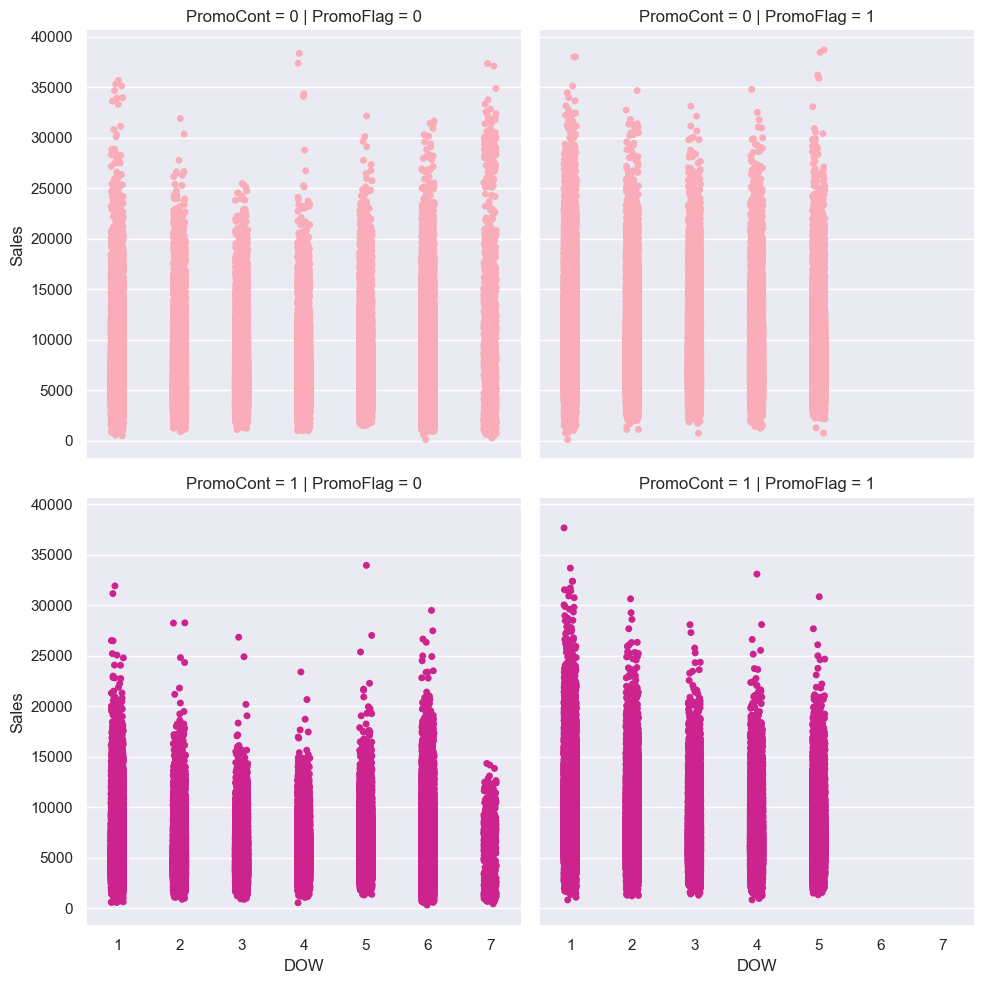

In [25]:
# sale per customer trends
sns.catplot(data = ldf_training_dataset, x = 'DOW', y = "Sales", 
               col = 'PromoFlag', 
               row = 'PromoCont',
               hue = 'PromoCont',
               palette = 'RdPu') 

There are several things here:

- In case of no promotion, both PromoFlag and PromoCont are equal to 0, Sales tend to peak on `Sunday`. Though we should note that LocalityType 3 doesn't work on Sundays. So it is mainly data from `LocalityType 1, 2 and 4`.
- On the contrary, stores that run the promotion tend to make most of the Sales on `Monday`. This fact could be a good indicator for marketing campaigns. The same trend follow the stores which have both promotion at the same time `(PromoFlag and PromoCont are equal to 1)`.
- PromoCont alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also proved by the blue pale area on the heatmap above.


### 2.5 Conclusion of EDA
- The most selling and crowded LocalityType is `type1`.
- The best "Sale per Customer" LocalityType `type4` indicates to the higher Buyer Cart. To benefit from this fact, company can consider proposing bigger variety of its products.
- Low SalePerCustomer amount for LocalityType `type2` indicates to the possible fact that people shop there essentially for "small" things. Eventhough this LocalityType generated the least amount of sales and customers over the whole period, it shows a great potential.
- Customers tends to buy more on `Mondays` when there's one promotion `(PromoFlag=1)` and on Sundays when there's no promotion at all `(both PromoFlag and PromoCont are equal to 0)`.
- PromoCont alone doesn't seem to be correlated to any significant change in the Sales amount.

<br/><hr/>

# 3. Time Series Analysis and Forecasting with Prophet

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called `Prophet`. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing automated forecasting which are already implemented in R at scale in Python 3.

### 3.1 Forecasting for the next 4 weeks for the first store

In [26]:
# sales for the store number 1
sales = ldf_training_dataset[ldf_training_dataset.StoreID == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [27]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
664,2013-01-02,5530
663,2013-01-03,4327
662,2013-01-04,4486
661,2013-01-05,4997
659,2013-01-07,7176


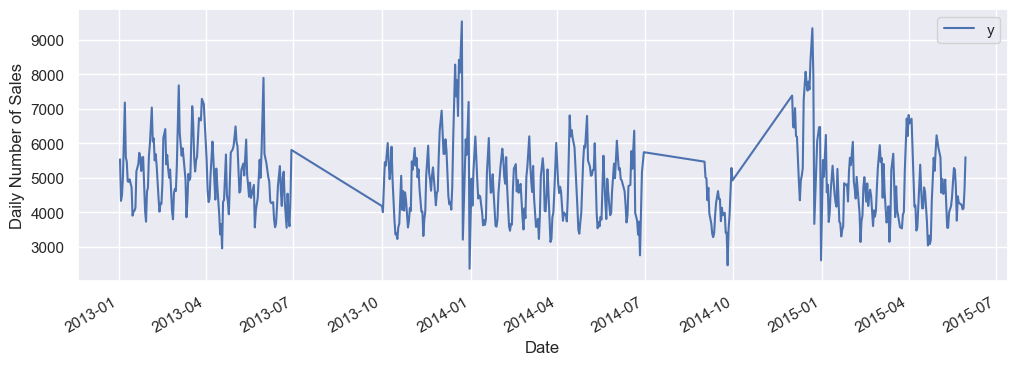

In [28]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### 3.2 Modeling Holidays

Prophet also allows to model for holidays.

The HolidayFlag variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school/university holidays in the dataset at which ceratin stores are also closing their doors.

In [29]:
# create holidays dataframe
state_dates = ldf_training_dataset[(ldf_training_dataset.HolidayFlag == 'h1') | (ldf_training_dataset.HolidayFlag == 'h2') & (ldf_training_dataset.HolidayFlag == 'h3')].loc[:, 'Date'].values
school_dates = ldf_training_dataset[ldf_training_dataset.SchUnivClose == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2013-10-03
1,state_holiday,2014-06-19
2,state_holiday,2013-05-30
3,state_holiday,2014-06-19
4,state_holiday,2013-05-30


### 3.3 Fit Model

In [30]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
581,2015-07-05
582,2015-07-06
583,2015-07-07
584,2015-07-08
585,2015-07-09
586,2015-07-10
587,2015-07-11


### 3.4 Get Predictions

In [31]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
581,2015-07-05,"6,443.4545","4,759.0225","7,979.2312"
582,2015-07-06,"7,059.6535","5,426.5242","8,710.2451"
583,2015-07-07,"6,875.7242","5,181.1980","8,605.0576"
584,2015-07-08,"7,169.1540","5,466.0779","8,717.2334"
585,2015-07-09,"7,426.6049","5,801.1284","9,187.1759"
586,2015-07-10,"8,157.1796","6,581.9146","9,794.4631"
587,2015-07-11,"8,964.2044","7,388.4036","10,665.9166"


# 4. The improvement driven by the solution provided

The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [32]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

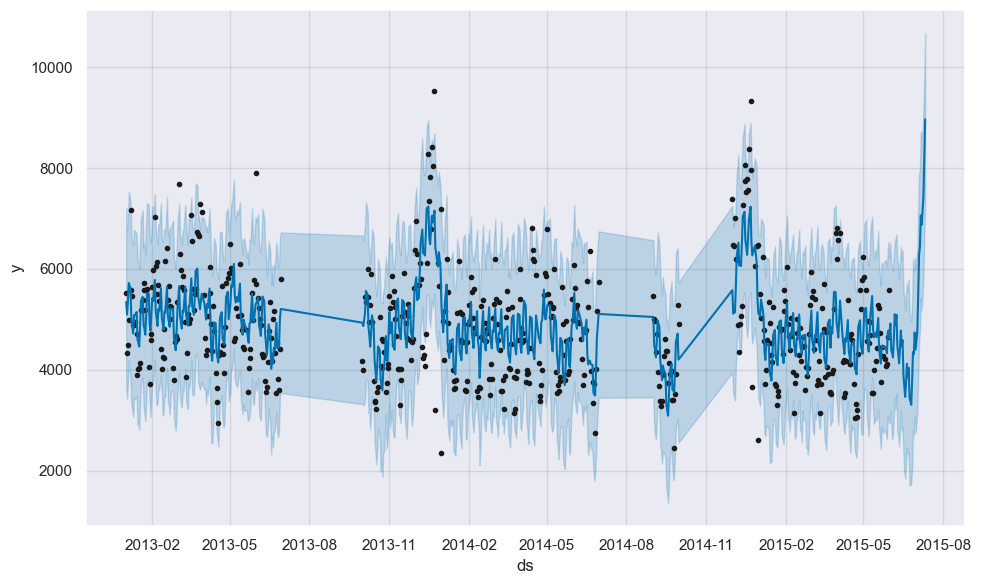

In [33]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

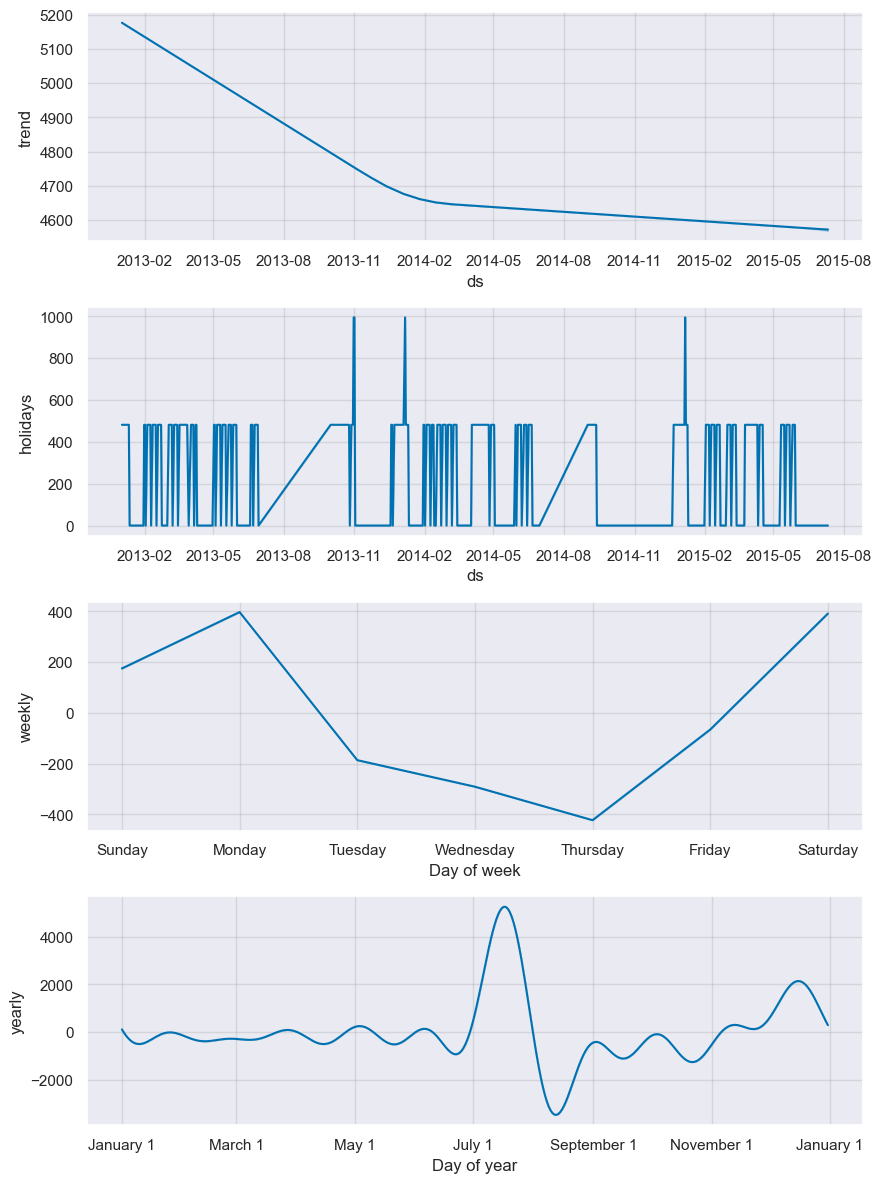

In [34]:
my_model.plot_components(forecast);

* The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time.
* The second shows the holiays gaps included in the model. 
* The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while 
* The forth plot shows that the most buzy season occurs during the Christmas holidays.

<hr/>

# 5. Conclusion

*Advantages*

- A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet).
- Easily implemented, which runs a complex grid search and sophisticated algorithm behind the scene.

*Drawbacks*

- Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are PromoFlag and Customer.
- Even though Prophet offers an automated solution, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.

<center><h1>End Here</h1></center>